
0. import data
1.   Define objective function (total time = travel time + waiting time + inspection time)
2.   Generate population (random matrix NPOP x (n+2*k))


*   NPOP= number of individuals in population
*   n=number of establishments
*   k=0,1*n= number of vehicles
*   2*k is added to consider starting and ending point of each vehicle
3. evaluate fitness
* (-)objective function (greatest fit the one with less total time)
4. order population by fitness
5.   select parents
6.   crossover
7. mutation
8. update population
9. evaluate fitness
10. order population by fitness
11. go back to 5 until stopping criteria



# Import Data

In [1]:
# skip if you want to import data locally
import numpy as np
import copy, random, math
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from collections import deque
import time

# importing data from google drive cloud
def import_excel(): 
  url='https://drive.google.com/file/d/1vu3UhfxA61Ksu3z85LSqKeHusGynPeKn/view?usp=sharing'
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  df = pd.read_csv(url)
  distances = np.array(df.iloc[0:, 0:].values)


  url='https://drive.google.com/file/d/1lsplyuLXJ5W5WELVWlJEP0DiGVCY0faA/view?usp=sharing'
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  df2 = pd.read_csv(url)
  inspection_times=np.array(df2.iloc[:, 8].values) #inspection_times-array with inspection times
  latitudes=np.array(df2.iloc[:, 5].values)
  longitudes=np.array(df2.iloc[:, 6].values)

  column_data = df2.iloc[:, -1]
  data_list = [[int(x) for x in row.strip('][').split(', ')] for row in column_data]
  schedule = np.array(data_list)
  #np.set_printoptions(threshold=np.inf)   # to print ALL the lines
  return distances,inspection_times,schedule, latitudes, longitudes

In [6]:
# skip if you want to import data from cloud
import numpy as np
import copy, random, math
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from collections import deque
import time

# importing data locally
# WILL NOT WORK ON GOOGLE COLAB
def import_excel(): 
    #file_path=r'C:\Users\user\Desktop\ai\data.xlsx'
    file_path="/home/david/Desktop/Pratical work - group 15/data_ASAE.xlsx"
    df = pd.read_excel(file_path, sheet_name='distances')
    distances = np.array(df.iloc[1:, 1:].values, dtype=float) #distances-matrix with distances

    df2 = pd.read_excel(file_path, sheet_name='establishments')
    inspection_times=np.array(df2.iloc[:, 8].values) #inspection_times-array with inspection times
    latitudes=np.array(df2.iloc[:, 5].values)
    longitudes=np.array(df2.iloc[:, 6].values)

    # Extract the last column of the DataFrame
    column_data = df2.iloc[:, -1]
    # Convert the column data into a list of lists
    data_list = [[int(x) for x in row.strip('][').split(', ')] for row in column_data]
    # Convert the list of lists into a NumPy array
    schedule = np.array(data_list)
    return distances,inspection_times,schedule, latitudes, longitudes

# Travel time minimization




## Evaluate function

In [2]:
class InspectionRouteProblem:
    def __init__(self, distances, inspection_times, schedule, n):
        num_vehicles=int(n/10)
        self.distances = distances
        self.inspection_times = inspection_times
        self.schedule = schedule
        self.num_vehicles = num_vehicles
        self.num_establishments = 10
        
    def evaluate_solution(self, individual):
        routes = np.reshape(individual, (self.num_vehicles, self.num_establishments +2))
        previous_time=0
        total_time = 0
        for vehicle in routes: #iterates for each vehicle
            total_time_v = 0
            travel_time = 0
            inspection_time = 0           
            current_time = 9   #every route starts at 9 AM
            for i in range(len(vehicle) - 1):
                waiting_time = 0
                start = vehicle[i]
                end = vehicle[i + 1]
                travel_time += self.distances[start][end] / 3600 #time it took to get from establishment start to end, in hours
                inspection_time += self.inspection_times[start] / 60 #time it took to inspect establishment start, in hours
                open_hours = self.schedule[start]
                arrival_time = current_time + travel_time
                if arrival_time >= 24: #checks if the passes midnight
                    arrival_time -= 24
                if open_hours[int(arrival_time)] == 1: #checks if the establishment is open on arrival
                    current_time = arrival_time + self.inspection_times[start] / 60 #updates hour of the day
                else:
                    waiting_time += int(arrival_time) + 1 - arrival_time #process to calculate the waiting time until it opens
                    next_open_time = int(arrival_time) + 1
                    if next_open_time == 24:
                        next_open_time = 0
                    while open_hours[next_open_time] == 0:
                        waiting_time += 1
                        next_open_time += 1
                        if next_open_time == 24:
                          next_open_time = 0
                    current_time = arrival_time + waiting_time + self.inspection_times[start] / 60 #updates hour of the day
            total_time_v += travel_time + inspection_time + waiting_time #total time for this vehicle to inspect 10 establishments 
            if total_time_v>previous_time: #updates the longest route
                total_time=total_time_v
            previous_time=total_time_v
        return -total_time

## Auxiliary functions

In [3]:
def get_greatest_fit(population,scores):
    best_solution = population[0]
    best_score = scores[0]
    for i in range(1, len(population)):
        score = scores[i]
        if score > best_score:
            best_score = score
            best_solution = population[i]
    return best_solution, best_score

def ordered_random_two_point_crossover(solution_1, solution_2):
    #Performs ordered random two-point crossover between two solutions
    length = len(solution_1)
    crossover_points = sorted([random.randint(0, length), random.randint(0, length)])
    zeros = [i for i in range(length) if solution_1[i] == 0 or solution_2[i] == 0]
    child_1 = [0] * length
    child_2 = [0] * length
    
    # First child
    for i in range(crossover_points[0], crossover_points[1]):
        child_1[i] = solution_1[i]
    j = 0
    for i in range(length):
        if solution_2[i] not in child_1 and solution_2[i] != 0:
            if i not in zeros:
                child_1[i] = solution_2[i]
                j += 1
        else:
            child_1[i] = solution_1[i]
    
    # Second child
    for i in range(crossover_points[0], crossover_points[1]):
        child_2[i] = solution_2[i]
    j = 0
    for i in range(length):
        if solution_1[i] not in child_2 and solution_1[i] != 0:
            if i not in zeros:
                child_2[i] = solution_1[i]
                j += 1
        else:
            child_2[i] = solution_2[i]
    
    return child_1, child_2

def offspring(parents): #generates offspring through crossover
    num_parents = (len(parents))
    offspring = []
    for i in range(0, num_parents, 2):
        solution_1 = parents[i]
        solution_2 = parents[i+1]
        child_1, child_2 = ordered_random_two_point_crossover(solution_1, solution_2)
        # Convert strings to numpy arrays
        child_1 = np.array([int(digit) for digit in child_1[1:-1]])
        child_2 = np.array([int(digit) for digit in child_2[1:-1]])
        child_1= np.concatenate(([0], child_1, [0]))
        child_2= np.concatenate(([0], child_2, [0]))
        offspring.append(child_1)
        offspring.append(child_2)
    return offspring

def generate_random_solution(n):     #generates a random solution, that consists in one route
    values = np.random.permutation(np.arange(1, n + 1))
    values_with_zeros = []
    count = 0
    for i, val in enumerate(values):
        if count == 10:
            values_with_zeros.extend([0, 0])
            count = 0
        values_with_zeros.append(val)
        count += 1
    if count > 0 and count < 10:
        num_zeros = 10 - count
        values_with_zeros.extend([0] * num_zeros)
    return np.concatenate(([0], values_with_zeros, [0]))    

def generate_population(population_size,n):
    solutions = []
    for i in range(population_size):
        solutions.append(generate_random_solution(n))
    return solutions

def print_population(population):
    solutions = []
    for i in range(len(population)):
        print(f"Solution {i}: {population[i]}, {problem.evaluate_solution(population[i])}")
        solutions.append(population[i])
    return np.array(solutions)

def tournament_select(population, tournament_size, scores): #tournament selection
    population_copy = copy.deepcopy(population)
    best_solution = population_copy[0]
    best_score = scores[0]
    for i in range(tournament_size):
        index = np.random.randint(0, len(population_copy))
        score = scores[index]
        if score > best_score:
            best_score = score
            best_solution = population_copy[index]
        del population_copy[index]
    return best_solution

def replace_worst_individuals(population, offspring,scores):
    # sort population by fitness in ascending order
    
    sorted_indices = np.argsort(scores)
    sorted_population = [population[i] for i in sorted_indices]

    # replace the worst individuals in the sorted population with offspring
    num_offspring = len(offspring)
    for i in range(num_offspring):
        sorted_population[-(i+1)] = offspring[i]

    # return the updated population
    return sorted_population

def roulette_select(population,scores): #roulette selection
    score_sum = np.sum(scores)
    selection_probabilities = scores / score_sum
    return population[np.random.choice(len(population), p=selection_probabilities)]

def roulette_select_pool(population, pool_size, scores): #roulette selection to a pool
    pool = []
    for i in range(pool_size):
        selected_solution = roulette_select(population, scores)
        pool.append(selected_solution)
    return pool

def tournament_select_pool(population, pool_size, tournament_size, scores): #tournament selection to a pool
    pool = []
    for i in range(pool_size):
        selected_solution = tournament_select(population, tournament_size, scores)
        pool.append(selected_solution)
    return pool    

def roulette_and_tournament_select_pool(population, pool_size, tourn_p, tournament_size, scores): #combines roulette and tournament selection to a pool
    roulette_size = int(pool_size * (1 - tourn_p))
    tournament_pool_size = int(pool_size * tourn_p)
    pool = roulette_select_pool(population, roulette_size, scores)
    tournament_pool = tournament_select_pool(population, tournament_pool_size, tournament_size, scores)
    pool.extend(tournament_pool)
    return pool   

def pool_select_parents(population_size, pool, Pcross):  #selects parents from the pool with Pcross percentage of the population to be chose as parents
    num_parents = int(population_size * Pcross)
    if num_parents % 2 == 1:
      num_parents -= 1
    parent_indices = []
    selected_parents = set()
    while len(selected_parents) < num_parents:
        x = np.random.randint(len(pool))
        individual = tuple(pool[x])
        if individual not in selected_parents:
            selected_parents.add(individual)
            parent_indices.append(x)
    parents = [pool[i] for i in parent_indices]
    return parents
    
def mutate_solution(solution, problem):
    num_swaps=(problem.num_vehicles)  #makes the number of swaps in mutation be adjusted to the data size
    non_zero_indices = [i for i in range(len(solution)) if solution[i] != 0]
    indices = random.sample(non_zero_indices, num_swaps)
    for i in range(0, len(indices), 2):
        index_1 = indices[i]
        index_2 = indices[i+1]
        solution[index_1], solution[index_2] = solution[index_2], solution[index_1]
    return solution

def mutate_population(population, Pmutate,p_nei, problem,n):
    mutated_population = []
    #numbers = sum(population, [])
    #x=len(numbers)
    #y=int(x/12)
    #routes = np.reshape(population, (y,12))
    for individual in population:
        if np.random.rand() < Pmutate:
            if np.random.rand() <p_nei:    #gives p_nei probability of mutation be performed via local search (two-opt)
              mutated_individual = get_neighbour_solution(individual,problem,n)
            else:
              mutated_individual = mutate_solution(individual,problem)
        else:
            mutated_individual = individual
        mutated_population.append(mutated_individual)
    return mutated_population
                   

def evolve_population(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem,n):
    parents = pool_select_parents(population_size, roulette_and_tournament_select_pool(population,pool_size, tourn_p, tournament_size, scores), Pcross)
    offsp = offspring(parents)
    offsp=mutate_population(offsp, Pmutate,p_nei,problem,n)
    population=replace_worst_individuals(population, offsp,scores)    
    return population

def get_neighbour_solution(tour, problem,n): #two-opt
    zeros_indices = np.where(tour == 0)[0]  # get the indices of the zeros in the tour
    zeros_positions = zeros_indices.argsort()  # get the positions of the zeros in the tour
    tour_without_zeros = tour[tour != 0]  # remove the zeros from the tour
    best_tour = tour
    best_time = problem.evaluate_solution(tour)
    t = len(tour_without_zeros)
    for i in range(1, t-1, int(n/20)):
        for j in range(i+1, t,int(n/20)):
            new_tour_without_zeros = np.concatenate((tour_without_zeros[:i], tour_without_zeros[i:j+1][::-1], tour_without_zeros[j+1:]))
            count=0
            count_2=0
            new_tour=np.zeros(len(tour))
            for k in range(len(tour)):   
                if k != zeros_indices[count]:      
                    new_tour[k]=new_tour_without_zeros[count_2]
                    count_2+=1
                else:
                    count+=1  
            new_time = problem.evaluate_solution(new_tour.astype(int))
            if new_time > best_time:
                best_tour = new_tour
                best_time = new_time
    return best_tour.astype(int)

def problem(distances, inspection_times, schedule, n):
    problem = InspectionRouteProblem(distances, inspection_times, schedule, n)
    return problem

## Genetic Algorithm

In [4]:
#num_iterations is the max number of iterations without change in the optimal value
#population_size is self explainable
#n is the number of establishments
#Pcross is the percentage of the population we want to select as parents
#pool_size is the size of the pool, in which we put all the contestants to be selected as parents
#tourn_p is the percentage of the pool that is selected via tournament, the rest is with roullete
#tournament_size is how many "battles" I want to do in the tournament
#Pmutate is the probability of mutation
#p_nei is the probability of mutating with local search, via two-opt. It gives a better mutation, but requires more computational effort, therefor for big data sets should be smaller
#--------------------------------------------------------------------------

def genetic_algorithm(num_iterations, population_size, n, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, problem,  log=False):
    start_time = time.time()
    distances,inspection_times,schedule, latitudes, longitudes=import_excel() 
    problem=problem(distances, inspection_times, schedule, n)
       
    population = generate_population(population_size,n)
    #print_population(population)
    best_solution = population[0] # Initial solution
    best_score = problem.evaluate_solution(population[0])
    best_solution_generation = 0 # Generation on which the best solution was found
    iterations=num_iterations #saves the number of executed iterations
    generation_no = 0
    if log:
      print(f"Initial solution: {best_solution}, time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
    else:
      print(f"Initial solution: Time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
    best_scores = []
    best_solutions = []
    generations=[]
    while(num_iterations > 0):
        
        generation_no += 1
        
        scores = []
        # loop through each individual in the population
        for individual in population:
        # evaluate the individual's solution and append the score to the scores list
          scores.append(problem.evaluate_solution(individual))
        scores = np.array(scores)
        # Next generation
        population=evolve_population(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem,n)
        #print(f"population evolved in generation {generation_no}: {population}")
        # Checking the greatest fit among the current population
        greatest_fit, greatest_fit_score = get_greatest_fit(population,scores)
        if greatest_fit_score > best_score:
            best_solution = greatest_fit
            best_score = greatest_fit_score
            best_solution_generation = generation_no
            best_scores.append(-best_score)
            best_solutions.append(best_solution)
            generations.append(generation_no)
            if log:
                print(f"\nGeneration: {generation_no }")
                print(f"Solution: {best_solution}, score: {best_score}")
                #print_population(population)
        else:
            num_iterations -= 1
    end_time = time.time()
    time_running= round(end_time - start_time,3)
    if log:  
      print(f"  Final solution: {best_solution}, time to inspect all establishments: {int(abs(best_score))} h {int((abs(best_score) % 1)*60)} min")
    else:
      print(f"  Final solution: Time to inspect all establishments: {int(abs(best_score))} h {int((abs(best_score) % 1)*60)} min")
    print(f"  Found on generation {best_solution_generation}")
    print(f"  Number of vehicles utilized: {int(n/10)}")
    print(f"  Number of inspected economic operators: {n}")
    # plot evolution data  
    plt.plot(generations, best_scores)
    plt.xlabel('Generation')
    plt.ylabel('Time to inspect all establishments [h]')
    plt.title('Evolution of Best Solution')
    plt.show()

    #ID list
    vehicles = np.reshape(best_solution, (int(n/10), 12))
    # initialize table with headers
    table= PrettyTable()
    table.field_names = ['Vehicle', 'IDs']
    # iterate over each route in the list of routes
    for i, route in enumerate(vehicles):
      # add row to the table for the current route
      table.add_row([f'Vehicle {i+1}', route])
    # print the table
    print(table)
    print(f"total time spent running the algorithm: {time_running} s")
    print(f"number of iterations to reach the optimal solution: {best_solution_generation}")
    print(f"total number of iterations executed: {best_solution_generation+iterations}")
    return best_solution

### 20 establishments

In [ ]:
result_20_establishments = genetic_algorithm(100,20,20,0.7,100,0.4,4,0.5,0.2,problem) #20

### 100 establishments

Initial solution: Time to inspect all establishments: 27 h 28 min
  Final solution: Time to inspect all establishments: 12 h 1 min
  Found on generation 45
  Number of vehicles utilized: 10
  Number of inspected economic operators: 100


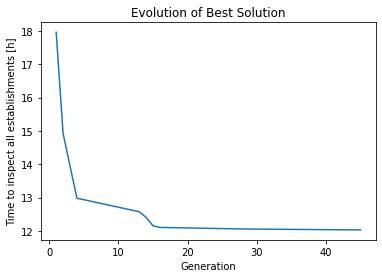

+------------+---------------------------------------------------+
|  Vehicle   |                        IDs                        |
+------------+---------------------------------------------------+
| Vehicle 1  |       [ 0 81 21 32 28 48 30 35 46 87 50  0]       |
| Vehicle 2  |       [ 0 39 24 63 68 29 34 18 91 62 95  0]       |
| Vehicle 3  |       [ 0 36 89  5 44 69 93  8 47 41 25  0]       |
| Vehicle 4  |       [ 0 90 55 57 76 13 90 83 37 75 73  0]       |
| Vehicle 5  | [  0  56  49   2   6  66   7 100  43  96  80   0] |
| Vehicle 6  |       [ 0 88 26 51 64 87 41 67 70 73 65  0]       |
| Vehicle 7  |       [ 0 98 24 77 19 40 84 27 79 61  3  0]       |
| Vehicle 8  |       [ 0 97 23 52 17 10  4 92 26 88 45  0]       |
| Vehicle 9  |       [ 0 86 25  8 85 94 33 14 53  1 22  0]       |
| Vehicle 10 |       [ 0 96 58 72 15 99 60 71 89 48 33  0]       |
+------------+---------------------------------------------------+
total time spent running the algorithm: 53.356 s
number of ite

In [ ]:
result_100_establishments = genetic_algorithm(50,30,100,0.7,120,0.5,10,0.7,0.4,problem)

### 500 establishments

Initial solution: [  0 116 466 463 305 299 144 492 368 461 231   0   0 497  24  95 479 141
 162  54 428 287 158   0   0 275 146  62 195  69 257 264 315 496 136   0
   0 411 303 204 290 260 172 163  28 498 445   0   0 449 109 219 367 185
 111  59 129 434 456   0   0 393 329 323 403 131 296 151 370 485 110   0
   0 304 481 181 487 174 362 429  60  70 222   0   0 192  81 425 308 239
  94 285 182  40 424   0   0 371 199  15 458  36 120 451 134 246 169   0
   0 455 280 420 432  35 210 196 347 433 328   0   0 179 369   5 409 213
 334 173 263 168 454   0   0 457  18  19  49 102  96 346 446 189  98   0
   0 437  56 490 107 150 145 245 389  79 224   0   0 105 160  37 499  51
 225  47 202  34 316   0   0 212 354 484 205 340  72 124 155  82 152   0
   0 238 344 383 301   4 314 349 360 423  55   0   0 229  16 122 251 471
 396 309  74 477 384   0   0 137  76 187  80  97 265 390 380  25 294   0
   0 177  90 480 159 139 440 140 214 175 149   0   0 448 357   3 271 379
 289 108 232 253  83   0   0 310 

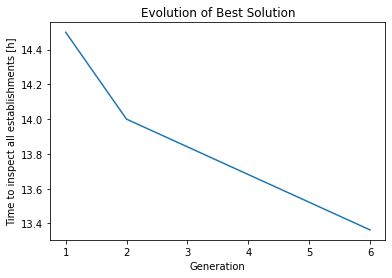

+------------+---------------------------------------------------+
|  Vehicle   |                        IDs                        |
+------------+---------------------------------------------------+
| Vehicle 1  | [  0 274 358 204 310 117 227  28 497  61 266   0] |
| Vehicle 2  | [  0  78 275  54 221  42 121 235 110 177 407   0] |
| Vehicle 3  | [  0 343  12 295 237   2 455 375  79 255 138   0] |
| Vehicle 4  | [  0  51 137 353 415 194  83   4 302 473 146   0] |
| Vehicle 5  | [  0  64  29 291 203 426 430  48 113 254 103   0] |
| Vehicle 6  | [  0 382 151 452 142  59 459 494 199  80 298   0] |
| Vehicle 7  | [  0 408  11  77  60 149 413 338 299 450 125   0] |
| Vehicle 8  | [  0 100 325 448 434  20 395 440  94 171 359   0] |
| Vehicle 9  | [  0 140  19 362 364 387 401 429  73 388 318   0] |
| Vehicle 10 | [  0  70 350 360 398   6 425  61 136 290 147   0] |
| Vehicle 11 | [  0  15 263 435 205 243 143 174 316 206 317   0] |
| Vehicle 12 | [  0 405 233 165 296 300 154 391 315 167 222   

In [ ]:
result_500_establishments = genetic_algorithm(50,20,500,0.7,300,0.5,10,0.6,0.1,problem)

### 1000 establishments

Initial solution: [  0 949  10 ... 342 217   0], time to inspect all establishments: 30 h 57 min
  Final solution: [  0 479 472 ... 267 803   0], time to inspect all establishments: 15 h 26 min
  Found on generation 5
  Number of vehicles utilized: 100
  Number of inspected economic operators: 1000


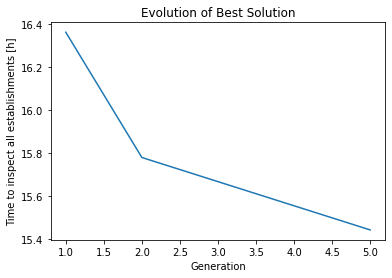

+-------------+---------------------------------------------------------------+
|   Vehicle   |                              IDs                              |
+-------------+---------------------------------------------------------------+
|  Vehicle 1  |       [  0 479 472 811 178  99 392  10 164 245 675   0]       |
|  Vehicle 2  | [   0  435  955  758  239  207 1000  437  358  110  232    0] |
|  Vehicle 3  |       [  0 329 969 285 304 397 170 451 744 823 976   0]       |
|  Vehicle 4  |       [  0 883 280 782 579 530 200  81 618 864 105   0]       |
|  Vehicle 5  |       [  0 951 335  25 794 904 596  68 960 411  29   0]       |
|  Vehicle 6  |       [  0 871 534 768 190 515  45 859 708 258 654   0]       |
|  Vehicle 7  |       [  0 230 824 747 237 600 381 367 981 502 443   0]       |
|  Vehicle 8  |       [  0 449 758 781 811 454 824 201 212 882 867   0]       |
|  Vehicle 9  |       [  0 241 342 318 892 383 750  14 850  10 133   0]       |
|  Vehicle 10 |       [  0 361 756 547 4

In [ ]:
result_1000_establishments = genetic_algorithm(50,25,1000,0.6,700,0.4,20,0.3,0.1,problem)

## Simulated Annealing

In [5]:
#Simulated annealing

def get_neighbour_solution(tour, problem,n):
    zeros_indices = np.where(tour == 0)[0]  # get the indices of the zeros in the tour
    zeros_positions = zeros_indices.argsort()  # get the positions of the zeros in the tour
    tour_without_zeros = tour[tour != 0]  # remove the zeros from the tour
    best_tour = tour
    best_time = problem.evaluate_solution(tour)
    t = len(tour_without_zeros)
    for i in range(1, t-1, int(n/20)):
        for j in range(i+1, t,int(n/20)):
            new_tour_without_zeros = np.concatenate((tour_without_zeros[:i], tour_without_zeros[i:j+1][::-1], tour_without_zeros[j+1:]))
            count=0
            count_2=0
            new_tour=np.zeros(len(tour))
            for k in range(len(tour)):   
                if k != zeros_indices[count]:      
                    new_tour[k]=new_tour_without_zeros[count_2]
                    count_2+=1
                else:
                    count+=1  
            new_time = problem.evaluate_solution(new_tour.astype(int))
            if new_time > best_time:
                best_tour = new_tour
                best_time = new_time
    return best_tour.astype(int)

def get_sa_solution(num_iterations, problem,n, log=False):
    start_time = time.time()
    distances,inspection_times,schedule, latitudes, longitudes=import_excel() 
    problem=problem(distances, inspection_times, schedule, n)    
    iteration = 0;
    iterations_exec=0 #number of iterations executed
    temperature = 1000;
    solution = generate_random_solution(n) # Best solution after 'num_iterations' iterations without improvement
    score = problem.evaluate_solution(solution)
    
    best_solution = copy.deepcopy(solution)
    best_score = score
    best_scores=[]
    print(f"Initial Solution:  {best_solution},  time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
    initial_solution = best_solution
    while iteration < num_iterations:
        temperature = temperature * 0.999  # Test with different cooling schedules
        iteration += 1
        iterations_exec+=1
        neighbour_solution = get_neighbour_solution(best_solution,problem,n)  #Test with Neighbour 1, 2 and 3
        neighbour_score = problem.evaluate_solution(neighbour_solution)
        delta = neighbour_score - score 
        
        if delta > 0 or np.exp(-delta/temperature) > random.random():
            solution = neighbour_solution
            score = neighbour_score
            if score > best_score:
                iteration = 0
                best_solution = copy.deepcopy(solution)
                best_score = score 
                best_scores.append(-score)
                if log:
                    print(f"Solution:       {best_solution}, score: {best_score},  Temp: {temperature}")
    end_time = time.time()
    time_running= round(end_time - start_time,3)                
    print(f"Final Solution: {best_solution}, time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
    print(f"  Number of vehicles utilized: {int(n/10)}")
    print(f"  Number of inspected economic operators: {n}")
    # plot evolution data  
    plt.plot(list(range(1, len(best_scores)+1)), best_scores)
    plt.xlabel('best solution')
    plt.ylabel('Time to inspect all establishments [h]')
    plt.title('Evolution of Best Solution')
    plt.show()

    #ID list
    vehicles = np.reshape(best_solution, (int(n/10), 12))
    # initialize table with headers
    table= PrettyTable()
    table.field_names = ['Vehicle', 'IDs']
    # iterate over each route in the list of routes
    for i, route in enumerate(vehicles):
      # add row to the table for the current route
      table.add_row([f'Vehicle {i+1}', route])
    # print the table
    print(table)
    print(f"total time spent running the algorithm: {time_running} s")
    print(f"number of iterations to reach the optimal solution: {iterations_exec-num_iterations}")
    print(f"total number of iterations executed: {iterations_exec}")    
    return best_solution, initial_solution 

### 20 establishments

Initial Solution:  [ 0  2  1 15 12  4  7 19 13 11  6  0  0  8  5  3 17 10 14  9 16 20 18  0],  time to inspect all establishments: 19 h 27 min
Final Solution: [ 0  2 12 20  7 13 11 15  9  1 19  0  0  5 16 17  3  4 10 14  6  8 18  0], time to inspect all establishments: 16 h 56 min
  Number of vehicles utilized: 2
  Number of inspected economic operators: 20


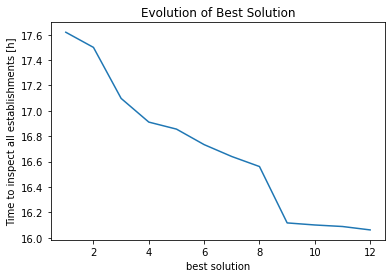

+-----------+---------------------------------------+
|  Vehicle  |                  IDs                  |
+-----------+---------------------------------------+
| Vehicle 1 | [ 0  2 12 20  7 13 11 15  9  1 19  0] |
| Vehicle 2 | [ 0  5 16 17  3  4 10 14  6  8 18  0] |
+-----------+---------------------------------------+
total time spent running the algorithm: 12.148 s
number of iterations to reach the optimal solution: 12
total number of iterations executed: 312


In [ ]:
SA_20_establishments=get_sa_solution(300,problem,20)
best = SA_20_establishments[0]
initial = SA_20_establishments[1]

#### Map visualization

In [ ]:
import folium

# generate initial and final solutions

# The establishment locations
distances, inspection_times, schedule, latitudes, longitudes = import_excel()
location_list = [(lat, long) for lat, long in zip(latitudes, longitudes)]
# Convert the location list to a numpy array
locations = np.array(location_list)

print("INITIAL SOLUTION:\n")
# The solution order
solution_order = initial

# Create the map object
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=13)

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    folium.PolyLine([[locations[start, 0], locations[start, 1]], [locations[end, 0], locations[end, 1]]], color='green').add_to(m)

# Plot the depot
folium.Marker(location=[latitudes[0], longitudes[0]], icon=folium.Icon(color='red')).add_to(m)

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
for i in establishments_in_path:
    folium.Marker(location=[latitudes[i-1], longitudes[i-1]], icon=folium.Icon(color='blue')).add_to(m)

# Show the map
m

INITIAL SOLUTION:



In [ ]:

print("FINAL SOLUTION:\n")
# The solution order
solution_order = best

# Create the map object
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=13)

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    folium.PolyLine([[locations[start, 0], locations[start, 1]], [locations[end, 0], locations[end, 1]]], color='green').add_to(m)

# Plot the depot
folium.Marker(location=[latitudes[0], longitudes[0]], icon=folium.Icon(color='red')).add_to(m)

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
for i in establishments_in_path:
    folium.Marker(location=[latitudes[i-1], longitudes[i-1]], icon=folium.Icon(color='blue')).add_to(m)

# Show the map
m


FINAL SOLUTION:



### 100 establishments

Initial Solution:  [  0  44  67  95  56 100  15  24  29  61  98   0   0  33  55  35  79  26
  81  13  68  14  43   0   0  84  71  46  50  12  73  52  63  41  20   0
   0  74  49  88  21   6  72  93  28  70  40   0   0  32  80  42  16  27
  75  65  89  18  39   0   0  25  85  23  90   2  87  57  45  99  51   0
   0  10  76  17  96  82  58  83  34  92  38   0   0  97   5  47  19  37
   8  36   3  66   1   0   0   7  62  60  69  77  30  86  54  53  64   0
   0  31  59  91  11   4  78  22   9  48  94   0],  time to inspect all establishments: 23 h 37 min
Final Solution: [  0  44  67  95  56 100  15  24  29  61  98   0   0  33  55  35  79  26
  81  13  68  14  43   0   0  84  71  46  50  12  73  52  63  41  20   0
   0  74  49  88  21   6  72  93  28  70  40   0   0  32  80  42  16  27
  75  65  89  18  39   0   0  25  85  23  90   2  87   9  22  78   4   0
   0  11  91  59  31  64  53  54  86  30  77   0   0  69  60  62   7   1
  66   3  36   8  37   0   0  19  47   5  97  38  92  76  17  

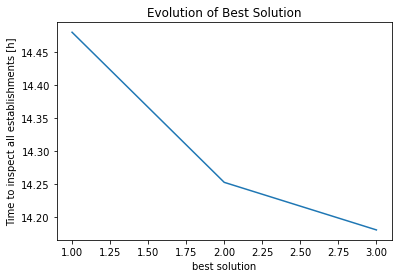

+------------+---------------------------------------------------+
|  Vehicle   |                        IDs                        |
+------------+---------------------------------------------------+
| Vehicle 1  | [  0  44  67  95  56 100  15  24  29  61  98   0] |
| Vehicle 2  |       [ 0 33 55 35 79 26 81 13 68 14 43  0]       |
| Vehicle 3  |       [ 0 84 71 46 50 12 73 52 63 41 20  0]       |
| Vehicle 4  |       [ 0 74 49 88 21  6 72 93 28 70 40  0]       |
| Vehicle 5  |       [ 0 32 80 42 16 27 75 65 89 18 39  0]       |
| Vehicle 6  |       [ 0 25 85 23 90  2 87  9 22 78  4  0]       |
| Vehicle 7  |       [ 0 11 91 59 31 64 53 54 86 30 77  0]       |
| Vehicle 8  |       [ 0 69 60 62  7  1 66  3 36  8 37  0]       |
| Vehicle 9  |       [ 0 19 47  5 97 38 92 76 17 96 82  0]       |
| Vehicle 10 |       [ 0 58 83 34 10 51 99 57 45 48 94  0]       |
+------------+---------------------------------------------------+
total time spent running the algorithm: 8.682 s
number of iter

In [ ]:
SA_100_establishments=get_sa_solution(50,problem,100)

### 500 establishments

Initial Solution:  [  0 484 377 130 113 412 327 154 292  80 248   0   0 236 351 333 467 276
 289 409 353 147 195   0   0 246 454 391 173 177 319 223 444 226 481   0
   0  51  35 133 374 490 447 215 457 323 367   0   0 477 314 390 417 182
  29 451 229 181 263   0   0 145 355 397 294  82 476 380 151 243 452   0
   0  39 320  92 305 165 291 443 293 270 283   0   0 388 227 277  16 266
 430 328 435 499 167   0   0 410 190 500 393 251   5 170 232  99 185   0
   0 475 400 426   3 110 335 442 396 317 157   0   0 326 371 281 204 112
 218  36  73  89 222   0   0 249 257 384 132 339 344 134 258 280 208   0
   0 237 241 282 383 272  56 496  22 144 168   0   0 494 106 146 369  57
 118  31 176 152 368   0   0 103 171 122 220 436 378 127 379  58  64   0
   0 425 288 120 441 213 350 128 406 119 188   0   0 360 202 419 250  12
 459 408  78 287 422   0   0 265 209 336 338 433  61  19 483 392  72   0
   0 114 242 189 278 161 450 240 295 413  53   0   0 104 411  66 193 159
  90 482 267  55 252   0   0 358

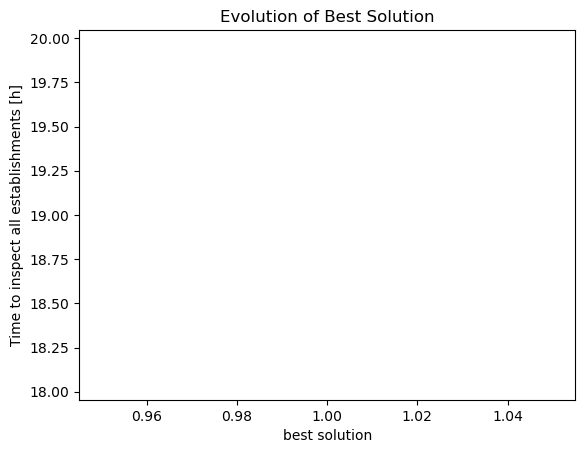

+------------+---------------------------------------------------+
|  Vehicle   |                        IDs                        |
+------------+---------------------------------------------------+
| Vehicle 1  | [  0 484 244 221 162 463 219 307 486  75 354   0] |
| Vehicle 2  | [  0 299 372 183 298 315  63 431 175 366 125   0] |
| Vehicle 3  | [  0 142 231 468 357 347 331 238  17 301  70   0] |
| Vehicle 4  | [  0 329  23 138 101 121  47 275 148 264  30   0] |
| Vehicle 5  | [  0 234 356 386 194 492 285 399  60 135 471   0] |
| Vehicle 6  | [  0 233  33 178 469  14 398 375 449 455 346   0] |
| Vehicle 7  | [  0  45 322 191 361 465 228 158 184 489   8   0] |
| Vehicle 8  | [  0 210 381 345 387 196 340  26 201  67  41   0] |
| Vehicle 9  | [  0 407 143 166  34  52  69 376 382 309 348   0] |
| Vehicle 10 | [  0 200 402 325   9  94  46 480 141 485 108   0] |
| Vehicle 11 | [  0 337   1  28 271 286  25 488 428 126 197   0] |
| Vehicle 12 | [  0 424  93 352  54  77  85 117 324 497 156   

In [6]:
SA_500_establishments=get_sa_solution(50,problem,500)

### 1000 establishments

Initial Solution:  [  0 544 884 ... 385 175   0],  time to inspect all establishments: 22 h 0 min
Final Solution: [  0 544 884 ... 385 175   0], time to inspect all establishments: 22 h 0 min
  Number of vehicles utilized: 100
  Number of inspected economic operators: 1000


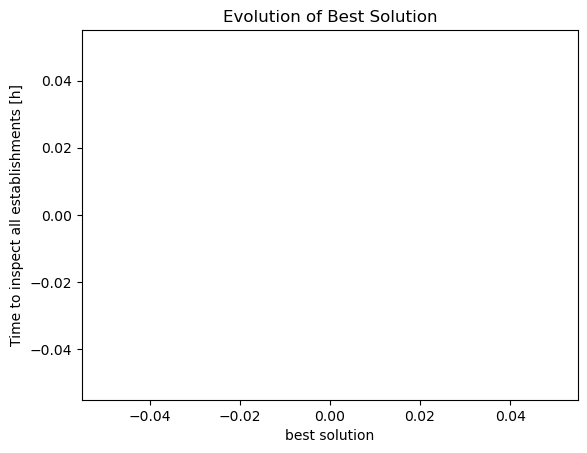

+-------------+---------------------------------------------------------------+
|   Vehicle   |                              IDs                              |
+-------------+---------------------------------------------------------------+
|  Vehicle 1  |       [  0 544 884 348 345 377  12 772 841 356 874   0]       |
|  Vehicle 2  |       [  0 996 565 617 806 634 311 242 203 948 224   0]       |
|  Vehicle 3  |       [  0 520 296 444 831  97 703 650 302 842 426   0]       |
|  Vehicle 4  |       [  0  79 187  80  36 165 859 431 564 182 937   0]       |
|  Vehicle 5  |       [  0 536 192 659 798 374 514 532  41 229 878   0]       |
|  Vehicle 6  |       [  0 235 409 496 838  60 883 445 983 381   1   0]       |
|  Vehicle 7  |       [  0 424 582 587 689 398 730 549 707 456 709   0]       |
|  Vehicle 8  |       [  0 273  76 141 190  27 278 917  33 318 254   0]       |
|  Vehicle 9  |       [  0 405 168 954 751 464 158 589 133 821 793   0]       |
|  Vehicle 10 |       [  0 949 359 157 4

In [7]:
SA_1000_establishments=get_sa_solution(50,problem,1000)

## Hill Climbing

In [ ]:
def generate_random_neighbor(solution, problem):
    num_swaps=(problem.num_vehicles)  #makes the number of swaps in mutation be adjusted to the data size
    non_zero_indices = [i for i in range(len(solution)) if solution[i] != 0]
    indices = random.sample(non_zero_indices, num_swaps)
    for i in range(0, len(indices), 2):
        index_1 = indices[i]
        index_2 = indices[i+1]
        solution[index_1], solution[index_2] = solution[index_2], solution[index_1]
    return solution

def hill_climbing(num_iterations, num_establishments,problem,  log=False):
  start_time = time.time()
  distances,inspection_times,schedule, latitudes, longitudes=import_excel()
  problem=problem(distances, inspection_times, schedule, num_establishments)  
    
  current_solution = generate_random_solution(num_establishments) # In the Hill Climbing algorithm, typically one initial solution is needed
  current_score = problem.evaluate_solution(current_solution)
  if log:
    print(f"Initial solution: {current_solution}, time to inspect all establishments: {-int(current_score)} h {int((current_score % 1)*60)} min")
  else:
    print(f"Initial solution. Time to inspect all establishments: {-int(current_score)} h {int((current_score % 1)*60)} min")
    
  best_solution_iteration = 0 # Iteration on which the best solution was found
  best_score = current_score
  best_solution = current_solution.copy()
  best_scores = []
    
  if log:
    print(f"Iteration 0: best score={-int(best_score)}, best solution={best_solution}")  
    
  for i in range(1, num_iterations + 1):
    # Generate neighboring solution
    neighbor_solution = generate_random_neighbor(current_solution,problem)
    neighbor_score = problem.evaluate_solution(neighbor_solution)
    # Check if neighboring solution is better
    if neighbor_score > current_score:
        current_solution = neighbor_solution
        current_score = neighbor_score

        if neighbor_score > best_score:
            best_solution = neighbor_solution.copy()
            best_solution_iteration = i
            best_score = neighbor_score
            if log:
                    print(f"Iteration {i}: best score={-int(best_score)}, best solution={best_solution}")
        elif log:
            print(f"Iteration {i}: score={neighbor_score}, solution={neighbor_solution}")
    best_scores.append(best_score)
    if log:
        print(f"Best score ({-int(best_score)}) found on iteration {best_solution_iteration}")
                

  if log:      
    print(f"Final solution: {best_solution} was found on iteration {best_solution_iteration}, time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
  else:
    print(f"Final solution was found on iteration {best_solution_iteration}, time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
  
  end_time = time.time()
  time_running= round(end_time - start_time,3)  

  # plot evolution data  
  best_scores_positive = [-score for score in best_scores]
  plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
  plt.xlabel('Iterations')
  plt.ylabel('Time to inspect all establishments')
  plt.title('Evolution of Best Solution')
  plt.show()    
  
  print(f"total time spent running the algorithm: {time_running} s")
  return current_solution

Initial solution. Time to inspect all establishments: 29 h 33 min
Final solution was found on iteration 101, time to inspect all establishments: 16 h 3 min


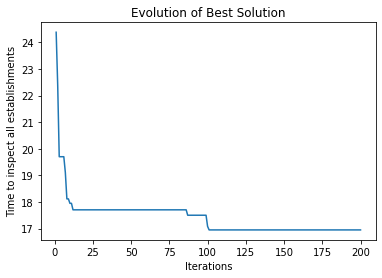

total time spent running the algorithm: 1.96 s


In [ ]:
hc_20_establishments=hill_climbing(200,20,problem)

Initial solution. Time to inspect all establishments: 21 h 0 min
Final solution was found on iteration 8, time to inspect all establishments: 16 h 31 min


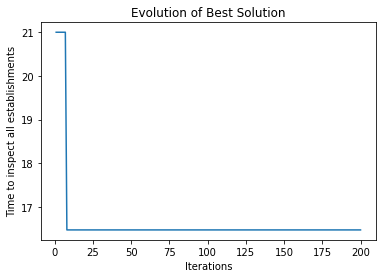

total time spent running the algorithm: 1.584 s


In [ ]:
hc_100_establishments=hill_climbing(200,100,problem)

# Resource allocation minimization

## Evaluation function

In [2]:
#Evaluation function
INSPECTION_TIME = 5/60  # it takes 5 min (300 sec) to inspect each establishment
class ResourceAllocationMinimization:
    def __init__(self, distances, inspection_times, schedule, n):
        self.distances = distances
        self.inspection_time = inspection_times / 3600
        self.schedule = schedule
        self.num_establishments = n

    # solution is a list of establishment indices, e.g. [4 1 5 3 2]
    def evaluate_solution(self, solution):
        route = list(solution)
        total_travel_time = self.distances[0][route[0]] / 3600
        total_inspection_time = 0
        total_waiting_time = 0                  
        waiting_time = 0
        current_time = 9 + total_travel_time
        current_vehicle = 1
        visited_nodes = []

        for i in range(len(route) - 1):            
            waiting_time = 0
            start = route[i]
            end = route[i + 1]
            if current_time - 9 >= 8 or current_time + self.distances[start][end] / 3600 - 9 >= 8:
                current_vehicle += 1
                current_time = 9
                visited_nodes = []
                # the new vehicle starts at 9 am and works until 5 pm
                # it should start from node 0 and go to the next unvisited establishment
                total_travel_time += self.distances[0][route[i + 1]] / 3600
                current_time += self.distances[0][route[i + 1]] / 3600            
            total_travel_time += self.distances[start][end] / 3600
            open_hours = self.schedule[start]                          
            current_time += self.distances[start][end] / 3600
            # check if establishment is open
            if open_hours[int(current_time)] == 1:
                total_inspection_time += INSPECTION_TIME
                current_time += INSPECTION_TIME
            # if not, wait until it opens                 
            else:
                waiting_time += int(current_time) + 1 - current_time 
                next_open_time = int(current_time) + 1
                current_time += waiting_time
                while open_hours[next_open_time] == 0 and current_time - 9 <= 8:
                    waiting_time += 1
                    next_open_time += 1 
                    current_time += waiting_time                
                total_inspection_time += INSPECTION_TIME
                total_waiting_time += waiting_time
                current_time += INSPECTION_TIME
            visited_nodes.append(start)  
        total_time = total_travel_time + total_inspection_time + total_waiting_time
        return (-current_vehicle)
        return (-current_vehicle)


def problem2(distances, inspection_time, schedule, n):
    problem = ResourceAllocationMinimization(distances, inspection_time, schedule, n)
    return problem

## Auxiliary functions

In [3]:
# auxiliary functions
def pool_select_parents(population_size, pool, Pcross):  #selects parents from the pool with Pcross percentage of the population to be chose as parents
    num_parents = int(population_size * Pcross)
    if num_parents % 2 == 1:
      num_parents -= 1
    parent_indices = []
    selected_parents = set()
    while len(selected_parents) < num_parents:
        x = np.random.randint(len(pool))
        individual = tuple(pool[x])
        if individual not in selected_parents:
            selected_parents.add(individual)
            parent_indices.append(x)
    parents = [pool[i] for i in parent_indices]
    return parents

def roulette_select(population,scores): #roulette selection
    score_sum = np.sum(scores)
    selection_probabilities = scores / score_sum
    return population[np.random.choice(len(population), p=selection_probabilities)]

def roulette_select_pool(population, pool_size, scores): #roulette selection to a pool
    pool = []
    for i in range(pool_size):
        selected_solution = roulette_select(population, scores)
        pool.append(selected_solution)
    return pool

def tournament_select_pool(population, pool_size, tournament_size, scores): #tournament selection to a pool
    pool = []
    for i in range(pool_size):
        selected_solution = tournament_select(population, tournament_size, scores)
        pool.append(selected_solution)
    return pool    

def roulette_and_tournament_select_pool(population, pool_size, tourn_p, tournament_size, scores): #combines roulette and tournament selection to a pool
    roulette_size = int(pool_size * (1 - tourn_p))
    tournament_pool_size = int(pool_size * tourn_p)
    pool = roulette_select_pool(population, roulette_size, scores)
    tournament_pool = tournament_select_pool(population, tournament_pool_size, tournament_size, scores)
    pool.extend(tournament_pool)
    return pool   

def tournament_select(population, tournament_size, scores): #tournament selection
    population_copy = copy.deepcopy(population)
    best_solution = population_copy[0]
    best_score = scores[0]
    for i in range(tournament_size):
        index = np.random.randint(0, len(population_copy))
        score = scores[index]
        if score > best_score:
            best_score = score
            best_solution = population_copy[index]
        del population_copy[index]
    return best_solution

def offspring(parents): #generates offspring through crossover
    num_parents = (len(parents))
    offspring = []
    for i in range(0, num_parents, 2):
        solution_1 = parents[i]
        solution_2 = parents[i+1]
        child_1, child_2 = ordered_random_two_point_crossover(solution_1, solution_2)
        # Convert strings to numpy arrays
        child_1 = np.array([int(digit) for digit in child_1[1:-1]])
        child_2 = np.array([int(digit) for digit in child_2[1:-1]])
        child_1= np.concatenate(([0], child_1, [0]))
        child_2= np.concatenate(([0], child_2, [0]))
        offspring.append(child_1)
        offspring.append(child_2)
    return offspring

def ordered_random_two_point_crossover(solution_1, solution_2):
    #Performs ordered random two-point crossover between two solutions
    length = len(solution_1)
    crossover_points = sorted([random.randint(0, length), random.randint(0, length)])
    zeros = [i for i in range(length) if solution_1[i] == 0 or solution_2[i] == 0]
    child_1 = [0] * length
    child_2 = [0] * length
    
    # First child
    for i in range(crossover_points[0], crossover_points[1]):
        child_1[i] = solution_1[i]
    j = 0
    for i in range(length):
        if solution_2[i] not in child_1 and solution_2[i] != 0:
            if i not in zeros:
                child_1[i] = solution_2[i]
                j += 1
        else:
            child_1[i] = solution_1[i]
    
    # Second child
    for i in range(crossover_points[0], crossover_points[1]):
        child_2[i] = solution_2[i]
    j = 0
    for i in range(length):
        if solution_1[i] not in child_2 and solution_1[i] != 0:
            if i not in zeros:
                child_2[i] = solution_1[i]
                j += 1
        else:
            child_2[i] = solution_2[i]
    
    return child_1, child_2


def replace_worst_individuals(population, offspring,scores):
    # sort population by fitness in ascending order
    
    sorted_indices = np.argsort(scores)
    sorted_population = [population[i] for i in sorted_indices]

    # replace the worst individuals in the sorted population with offspring
    num_offspring = len(offspring)
    for i in range(num_offspring):
        sorted_population[-(i+1)] = offspring[i]

    # return the updated population
    return sorted_population


def get_greatest_fit(population,scores):
    best_solution = population[0]
    best_score = scores[0]
    for i in range(1, len(population)):
        score = scores[i]
        if score > best_score:
            best_score = score
            best_solution = population[i]
    return best_solution, best_score

def generate_random_solution2(n):
    # Generate a random permutation of the numbers from 1 to k
    values = np.random.permutation(np.arange(1, n + 1))
    return [int(x) for x in values]

# initial solution
def generate_population2(population_size,n): 
    solutions = []
    for i in range(population_size):
        solutions.append(generate_random_solution2(n))
    return solutions

    

def invert_mutation(solution):
    """
    Randomly select two cities in the genotype and reverse the order of the cities between them.
    """
    # Select two distinct cities at random
    i, j = sorted(random.sample(range(1, len(solution)-1), 2))
    # Reverse the order of cities between i and j
    new_solution = solution[:i] + solution[j:i-1:-1] + solution[j+1:]
    return new_solution

def swap_mutation(solution):
    # Select two random cities to swap
    idx1, idx2 = random.sample(range(1, len(solution) - 1), 2)
    # Swap their positions in the genotype
    solution[idx1], solution[idx2] = solution[idx2], solution[idx1]
    return solution

def mutate_population2(population, Pmutate,p_nei, problem):
    mutated_population = []
    for individual in population:
        if np.random.rand() < Pmutate:
            if np.random.rand() <p_nei:
              mutated_individual = swap_mutation(individual)
            else:
              mutated_individual = swap_mutation(individual)
        else:
            mutated_individual = individual
        mutated_population.append(mutated_individual)
    return mutated_population
                   

def evolve_population2(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem):
    parents = pool_select_parents(population_size, roulette_and_tournament_select_pool(population,pool_size, tourn_p, tournament_size, scores), Pcross)
    offsp = offspring(parents)
    offsp=mutate_population2(offsp, Pmutate,p_nei,problem)
    population = replace_worst_individuals(population, offsp,scores)
    return population

def evolve_population(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem,n):
    parents = pool_select_parents(population_size, roulette_and_tournament_select_pool(population,pool_size, tourn_p, tournament_size, scores), Pcross)
    offsp = offspring(parents)
    offsp=mutate_population(offsp, Pmutate,p_nei,problem,n)
    population=replace_worst_individuals(population, offsp,scores)    
    return population

## Genetic Algorithm

In [4]:
#Resource allocation minimization - Genetic Algorithm
# 50,100,25,0.6,700,0.4,20,0.3,0.1
def genetic_algorithm2(num_iterations, num_establishments, population_size, Pcross=0.6, pool_size=700, tourn_p=0.4, tournament_size=10, Pmutate=0.6, p_nei=0.3,  log=False):
  start_time = time.time()
  distances,inspection_times,schedule, latitudes, longitudes=import_excel()
  problem=problem2(distances, INSPECTION_TIME, schedule, num_establishments)  
  population = generate_population2(population_size,num_establishments)

  initial_solution = population[0] # Initial solution
  best_solution = initial_solution.copy()
  best_score = problem.evaluate_solution(population[0])
  best_solution_generation = 0 # Generation on which the best solution was found
  generation_no = 0
    
  print(f"Initial solution: {best_solution}, number of vehicles required to inspect all establishments: {-int(best_score)}")
  best_scores = []
  best_solutions = []
  generations=[]
  while(num_iterations > 0):
    generation_no += 1
    scores = []
    for individual in population:
      scores.append(problem.evaluate_solution(individual))
    scores = np.array(scores)

    population = evolve_population2(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem)
    # Checking the greatest fit among the current population
    greatest_fit, greatest_fit_score = get_greatest_fit(population,scores)
    if greatest_fit_score > best_score:
            best_solution = greatest_fit
            best_score = greatest_fit_score
            best_solution_generation = generation_no
            best_scores.append(-best_score)
            best_solutions.append(best_solution)
            generations.append(generation_no)
            if log:
                print(f"\nGeneration: {generation_no }")
                print(f"Solution: {best_solution}, score: {best_score}")
    else:
            num_iterations -= 1
            generations.append(generation_no)
            best_scores.append(-best_score)
    if log:
        print(f"best solution {generation_no}th generation - {best_score}")  # uncomment to check every geenration difference
  end_time = time.time()
  time_running= round(end_time - start_time,3)  
  print(f"  Final solution: best_solution, vehicles required to inspect all establishments: {-best_score} ")
  print(f"  Found on generation {best_solution_generation}")
  # plot evolution data  
  plt.plot(list(range(1, len(best_scores)+1)), best_scores)
  plt.plot(generations, best_scores)
  plt.xlabel('Generation')
  plt.ylabel('number of vehicles required')
  plt.title('Evolution of Best Solution')
  plt.show()

  print(f"total time spent running the algorithm: {time_running} s")
  return best_solution, initial_solution, best_scores

Initial solution: [468, 714, 964, 10, 748, 789, 574, 400, 275, 7, 515, 260, 427, 210, 588, 517, 879, 584, 365, 79, 623, 959, 553, 492, 144, 804, 317, 38, 738, 314, 475, 793, 494, 218, 889, 5, 162, 611, 609, 784, 51, 763, 910, 726, 843, 395, 664, 225, 635, 944, 710, 82, 656, 862, 299, 868, 895, 300, 55, 853, 681, 255, 662, 78, 938, 240, 99, 18, 907, 969, 269, 200, 730, 191, 399, 117, 226, 832, 693, 501, 513, 896, 437, 307, 250, 812, 940, 734, 737, 521, 547, 194, 213, 230, 305, 130, 160, 258, 373, 106, 579, 546, 955, 805, 497, 937, 604, 720, 686, 754, 138, 74, 337, 819, 465, 466, 678, 535, 570, 445, 782, 590, 16, 885, 386, 899, 388, 978, 486, 700, 836, 977, 989, 355, 105, 471, 327, 73, 57, 908, 390, 745, 460, 45, 612, 223, 518, 31, 930, 369, 425, 963, 939, 207, 118, 703, 620, 654, 283, 701, 90, 23, 952, 601, 624, 70, 72, 838, 949, 246, 59, 277, 855, 986, 406, 534, 614, 13, 828, 3, 854, 736, 684, 870, 830, 665, 172, 839, 496, 284, 52, 286, 30, 539, 272, 592, 53, 294, 811, 755, 451, 345, 5

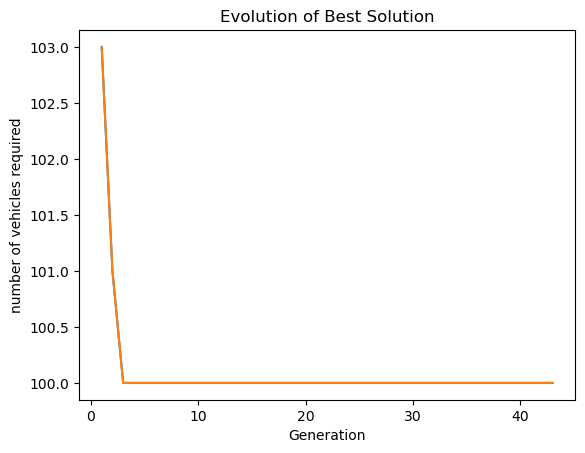

total time spent running the algorithm: 45.223 s


In [7]:
resourceAllocationResult = genetic_algorithm2(40,1000,25,0.6,1500,0.4,20,0.1,0.1)

## Simulated Annealing

In [5]:
def swap_establishments(solution):
    # Choose two random establishments to swap
    i, j = random.sample(range(len(solution)), 2)
    # Swap the establishments in the solution
    new_solution = solution.copy()
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    return new_solution

def simulated_annealing(num_iterations, num_establishments, log=False):
    start_time = time.time()
    distances, inspection_times, schedule, latitudes, longitudes = import_excel()
    problem = problem2(distances, inspection_times, schedule, num_establishments)    
    iteration = 0
    iterations_exec = 0  # number of iterations executed
    best_iteration = 0
    temperature = 1000
    cooling_rate = 0.95
    solution = generate_random_solution2(num_establishments)
    score = -problem.evaluate_solution(solution)  # Negate the score
    best_solution = copy.deepcopy(solution)
    best_score = score
    best_scores = []
    print(f"Initial Solution: best_solution, vehicles to inspect all establishments: {best_score}")
    initial_solution = best_solution
    while iteration < num_iterations:
        new_solution = swap_establishments(solution)
        new_score = -problem.evaluate_solution(new_solution)  # Negate the score
        
        if new_score < score:
            # Accept the new solution if it is better
            solution = new_solution
            score = new_score
        else:
            # Accept the new solution with probability based on temperature
            delta_score = new_score - score
            acceptance_probability = math.exp(-delta_score / temperature)
            if random.random() < acceptance_probability:
                solution = new_solution
                score = new_score
        
        # Update the best solution if necessary
        if score < best_score:
            best_solution = copy.deepcopy(solution)
            best_score = score
            best_iteration = iteration
        
        # Reduce the temperature by the cooling rate
        temperature *= cooling_rate
        iteration += 1
        iterations_exec += 1
        
        # Log the best score and solution
        best_scores.append(-best_score)
        if log and iterations_exec % 100 == 0:
            print(f"Iteration {iterations_exec}, Best solution: best_solution, vehicles to inspect all establishments: {-best_score}")
    
    end_time = time.time()
    time_running= round(end_time - start_time,3) 
    
    print(f"Best solution: best_solution, vehicles to inspect all establishments: {best_score}, Time elapsed: {time_running:.2f} seconds")
    print(f"Best solution found at iteration {best_iteration}")
    
    # plot evolution data  
    best_scores_positive = [-score for score in best_scores]
    plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
    plt.xlabel('Iterations')
    plt.ylabel('Number of vehicles to inspect all establishments')
    plt.title('Evolution of Best Solution')
    plt.show()    
    
    print(f"total time spent running the algorithm: {time_running} s")

    return best_solution, initial_solution, best_scores_positive


Initial Solution: best_solution, vehicles to inspect all establishments: 110
Best solution: best_solution, vehicles to inspect all establishments: 86, Time elapsed: 5.49 seconds
Best solution found at iteration 649


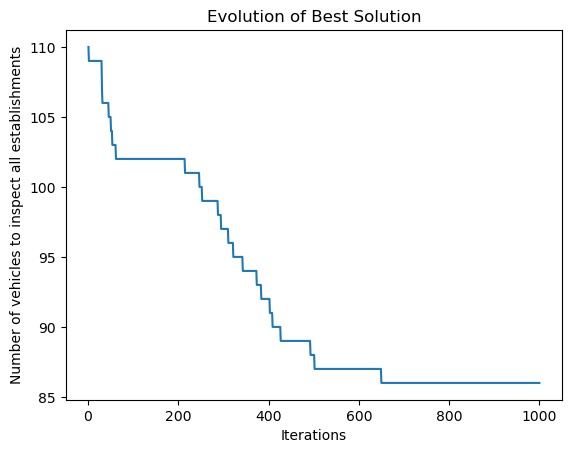

total time spent running the algorithm: 5.486 s


In [6]:
SA_resourceAllocation=simulated_annealing(1000,1000)

Plot the visiting graph on a real map using latitudes and longitudes of the establishments

In [9]:
import folium

# get initial solution
initial_solution = SA_resourceAllocation[1]

# Import locations
distances, inspection_times, schedule, latitudes, longitudes = import_excel()
location_list = [(lat, long) for lat, long in zip(latitudes, longitudes)]
# Convert the location list to a numpy array
locations = np.array(location_list)

print("INITIAL SOLUTION:\n")
solution_order = initial_solution

# Create the map object
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=13)

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    folium.PolyLine([[locations[start, 0], locations[start, 1]], [locations[end, 0], locations[end, 1]]], color='green').add_to(m)

# Plot the depot
folium.Marker(location=[latitudes[0], longitudes[0]], icon=folium.Icon(color='red')).add_to(m)

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
for i in establishments_in_path:
    folium.Marker(location=[latitudes[i-1], longitudes[i-1]], icon=folium.Icon(color='blue')).add_to(m)

# Show the map
m

INITIAL SOLUTION:



In [10]:
print("FINAL SOLUTION:\n")

# get final solution
best_solution = SA_resourceAllocation[0]

# The solution order
solution_order = best_solution

# Create the map object
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=13)

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    folium.PolyLine([[locations[start, 0], locations[start, 1]], [locations[end, 0], locations[end, 1]]], color='green').add_to(m)

# Plot the depot
folium.Marker(location=[latitudes[0], longitudes[0]], icon=folium.Icon(color='red')).add_to(m)

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
for i in establishments_in_path:
    folium.Marker(location=[latitudes[i-1], longitudes[i-1]], icon=folium.Icon(color='blue')).add_to(m)

# Show the map
m


FINAL SOLUTION:



## Hill Climbing

In [6]:
def generate_neighbor(solution):
    n = len(solution)
    i, j = np.random.randint(n, size=2)
    neighbor = solution.copy()
    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor

def hill_climbing(num_iterations, num_establishments,  log=False):
  start_time = time.time()
  distances,inspection_times,schedule, latitudes, longitudes=import_excel()
  problem=problem2(distances, INSPECTION_TIME, schedule, num_establishments)  
    
  initial_solution = generate_population2(1,num_establishments)[0] # In the Hill Climbing algorithm, typically one initial solution is needed
  current_solution = initial_solution.copy()
  current_score = problem.evaluate_solution(current_solution)
  if log:
    print(f"Initial solution: {current_solution}, number of vehicles required to inspect all establishments: {-int(current_score)}")
  else:
    print(f"Initial solution. Number of vehicles required to inspect all establishments: {-int(current_score)}")
    
  best_solution_iteration = 0 # Iteration on which the best solution was found
  best_score = current_score
  best_solution = current_solution.copy()
  best_scores = []
    
  if log:
    print(f"Iteration 0: best score={-int(best_score)}, best solution={best_solution}")  
    
  for i in range(1, num_iterations + 1):
    # Generate neighboring solution
    neighbor_solution = generate_neighbor(current_solution)
    neighbor_score = problem.evaluate_solution(neighbor_solution)
    # Check if neighboring solution is better
    if neighbor_score > current_score:
        current_solution = neighbor_solution
        current_score = neighbor_score

        if neighbor_score > best_score:
            best_solution = neighbor_solution.copy()
            best_solution_iteration = i
            best_score = neighbor_score
            if log:
                    print(f"Iteration {i}: best score={-int(best_score)}, best solution={best_solution}")
        elif log:
            print(f"Iteration {i}: score={neighbor_score}, solution={neighbor_solution}")
    best_scores.append(best_score)
    if log:
        print(f"Best score ({-int(best_score)}) found on iteration {best_solution_iteration}")
                

  if log:      
    print(f"Final solution: {best_solution} was found on iteration {best_solution_iteration}, number of vehicles required to inspect all establishments: {-int(best_score)}")
  else:
    print(f"Final solution was found on iteration {best_solution_iteration}, number of vehicles required to inspect all establishments: {-int(best_score)}")
  
  end_time = time.time()
  time_running= round(end_time - start_time,3)  

  # plot evolution data  
  best_scores_positive = [-score for score in best_scores]
  plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
  plt.xlabel('Iterations')
  plt.ylabel('Number of vehicles to inspect all establishments')
  plt.title('Evolution of Best Solution')
  plt.show()    
  
  print(f"total time spent running the algorithm: {time_running} s")
  return current_solution, initial_solution, best_scores_positive

Initial solution. Number of vehicles required to inspect all establishments: 114
Final solution was found on iteration 937, number of vehicles required to inspect all establishments: 93


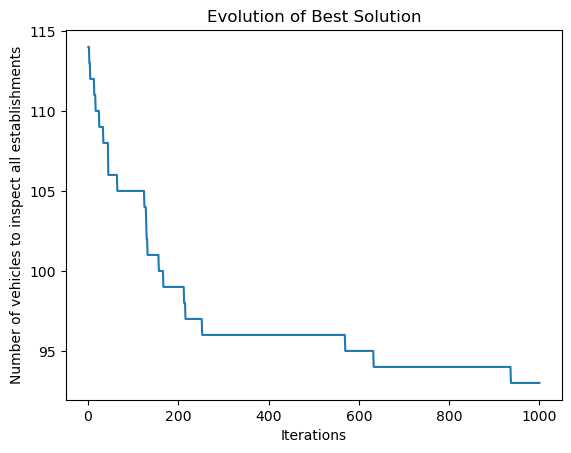

total time spent running the algorithm: 4.743 s


In [12]:
resourceAllocationResult = hill_climbing(1000, 1000)

## Tabu Search

In [7]:
def tabu_search(num_iterations, num_establishments, tabu_list_size=5, tabu_tenure=3, log=False):
    start_time = time.time()
    distances, inspection_times, schedule, latitudes, longitudes = import_excel()
    problem = problem2(distances, INSPECTION_TIME, schedule, num_establishments)  

    initial_solution = generate_population2(1, num_establishments)[0] # In the Hill Climbing algorithm, typically one initial solution is needed
    current_solution = initial_solution.copy()
    current_score = problem.evaluate_solution(current_solution)
    print(f"Parameters: num_iterations: {num_iterations}, num_establishments: {num_establishments}, tabu_list_size: {tabu_list_size}, tabu_tenure: {tabu_tenure}")
    print(f"Initial solution: {current_solution}, number of vehicles required to inspect all establishments: {-int(current_score)}")

    best_solution_iteration = 0 # Iteration on which the best solution was found
    best_score = current_score
    best_solution = current_solution.copy()
    if log:
        print(f"Iteration 0: best score={-int(best_score)}, best solution={best_solution}")  

    tabu_list = deque(maxlen=tabu_list_size)
    
    best_scores = []  # Keep track of the best score at each iteration
    best_scores.append(best_score)
    
    tabu_tenure_min = 1
    tabu_tenure_max = 5
    tabu_tenure_step = 1

    for it in range(num_iterations):
        # Generate all possible moves
        moves = []
        for i in range(num_establishments):
            for j in range(i + 1, num_establishments):
                move = (i, j)
                moves.append(move)

        # Evaluate each move and select the best one
        best_move = None
        best_move_score = float('-inf')
        for move in moves:
            # Skip move if it's in the tabu list
            if move in tabu_list:
                continue

            # Make the move and evaluate the score
            new_solution = current_solution.copy()
            new_solution[move[0]], new_solution[move[1]] = new_solution[move[1]], new_solution[move[0]]
            new_score = problem.evaluate_solution(new_solution)

            # Update best move
            if new_score > best_move_score:
                best_move = move
                best_move_score = new_score

        # Update current solution with the best move
        current_solution[best_move[0]], current_solution[best_move[1]] = current_solution[best_move[1]], current_solution[best_move[0]]
        current_score = best_move_score

        # Add move to tabu list
        tabu_list.append(best_move)

        # Update best solution if necessary
        if current_score > best_score:
            best_score = current_score
            best_solution = current_solution.copy()
            best_solution_iteration = it

        best_scores.append(best_score)  # Add the best score at this iteration to the list

        # Update tabu tenure based on recent solutions
        if it >= tabu_list_size:
            recent_solutions = [best_scores[i] for i in range(it-tabu_list_size, it)]
            if recent_solutions == sorted(recent_solutions, reverse=True):
                tabu_tenure = min(tabu_tenure+tabu_tenure_step, tabu_tenure_max)
            elif recent_solutions == sorted(recent_solutions):
                tabu_tenure = max(tabu_tenure-tabu_tenure_step, tabu_tenure_min)

        # Remove oldest move from tabu list if necessary
        if len(tabu_list) >= tabu_list_size:
            tabu_list.popleft()

        if log:
            print(f"Iteration {it+1}: best score={-int(best_score)}, best solution={best_solution}, tabu tenure={tabu_tenure}")

    print(f"Final solution: {best_solution} was found on iteration {best_solution_iteration}, number of vehicles required to inspect all establishments: {-int(best_score)}")

  
    end_time = time.time()
    time_running= round(end_time - start_time,3)  

    
        # plot evolution data  
    best_scores_positive = [-score for score in best_scores]
    plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
    plt.xlabel('Iterations')
    plt.ylabel('Number of vehicles to inspect all establishments')
    plt.title('Evolution of Best Solution')
    plt.show()  
    
    
    print(f"total time spent running the algorithm: {time_running} s")
    return best_solution, initial_solution, best_scores_positive

Parameters: num_iterations: 5, num_establishments: 300, tabu_list_size: 5, tabu_tenure: 3
Initial solution: [211, 119, 232, 185, 187, 3, 1, 258, 282, 41, 275, 177, 284, 59, 214, 78, 170, 189, 175, 257, 253, 75, 134, 79, 171, 270, 16, 299, 116, 101, 289, 114, 244, 146, 85, 200, 245, 221, 262, 196, 142, 71, 238, 193, 124, 131, 204, 135, 226, 137, 149, 12, 263, 73, 277, 125, 216, 184, 249, 141, 74, 118, 39, 157, 23, 228, 7, 20, 280, 246, 89, 151, 13, 11, 144, 288, 220, 206, 236, 165, 58, 115, 260, 155, 250, 87, 105, 19, 56, 241, 139, 267, 42, 40, 113, 53, 4, 45, 227, 46, 255, 202, 111, 66, 188, 264, 224, 197, 10, 37, 273, 231, 281, 47, 5, 297, 195, 190, 77, 64, 183, 51, 153, 109, 88, 174, 55, 72, 186, 254, 32, 80, 61, 223, 26, 276, 110, 271, 25, 86, 108, 279, 130, 96, 138, 261, 294, 248, 237, 68, 82, 272, 6, 34, 296, 21, 15, 143, 69, 167, 76, 266, 91, 182, 265, 243, 27, 94, 33, 148, 9, 90, 269, 127, 168, 213, 60, 205, 212, 156, 145, 176, 283, 92, 285, 208, 192, 30, 295, 22, 201, 99, 164, 

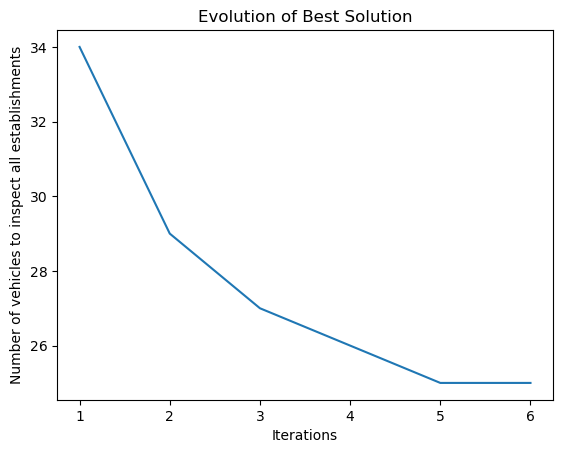

total time spent running the algorithm: 253.886 s


In [16]:
resource_allocation_TS = tabu_search(5, 300,5,3,True)

# User Interface

Is not supported by colab. Run on Jupyter

User Interface allows a user to input parameters and compare algorithms in a user-friendly way.
Note that it is most reasonable to compare Simulated Annealing, Hill Climbing and Genetic Algorithm, Tabu Search separetely, 
since for a large number of iterations Genetic Algorithm and Tabu Search may take a very long time to run (unlike SA and HC)

In [ ]:
import tkinter as tk
import time
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from functools import partial

def run_algorithm(algorithm, num_iterations, num_establishments, tabu_list_size, tabu_tenure, popsize):
    try:
        num_iterations = int(num_iterations)
        num_establishments = int(num_establishments)
        if tabu_list_size is not None:
            tabu_list_size = int(tabu_list_size)
        if tabu_tenure is not None:
            tabu_tenure = int(tabu_tenure)
        if popsize is not None:
            popsize = int(popsize)
    except ValueError:
        result_label.config(text=f"Invalid input values. Please enter integers. Type provided is {type(num_iterations)} values: {num_iterations}, {num_establishments}")
        return
    # call the algorithm function with the provided arguments
    # and print the result
    print("Solution is being generated, stand by...")
    
    if algorithm == 'hill_climbing':
        result_label.config(text="Solution is being generated, stand by...")
        start_time = time.time()
        best_solution, best_scores, best_scores_positive = hill_climbing(num_iterations, num_establishments)
        end_time = time.time()
        total_time = end_time - start_time

    elif algorithm == 'simulated_annealing':
        result_label.config(text="Solution is being generated, stand by...")
        start_time = time.time()
        best_solution, best_scores, best_scores_positive = simulated_annealing(num_iterations, num_establishments)
        end_time = time.time()
        total_time = end_time - start_time
        
    elif algorithm == 'genetic_algorithm':
        result_label.config(text="Solution is being generated, stand by...")
        start_time = time.time()
        best_solution, best_scores, best_scores_positive = genetic_algorithm2(num_iterations, num_establishments, population_size)
        end_time = time.time()
        total_time = end_time - start_time

    elif algorithm == 'tabu_search':
        result_label.config(text="Solution is being generated, stand by...")
        start_time = time.time()
        if tabu_list_size is not None and tabu_tenure is not None:
            best_solution, best_scores, best_scores_positive = tabu_search(num_iterations, num_establishments, tabu_list_size, tabu_tenure)
        else:
            best_solution, best_scores, best_scores_positive = tabu_search(num_iterations, num_establishments)
        end_time = time.time()
        total_time = end_time - start_time

    else:
        result_label.config(text="Invalid algorithm selection.")
        return

    
    # update the result label with the solution and time
    result_label.config(text=f"Initial solution. Number of vehicles required to inspect all establishments: {best_scores[0]}\nNumber of vehicles required to inspect all establishments: {best_scores[-1]}\n\nTotal time spent running the algorithm: {total_time:.3f} s")
    # plot the graph
    plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
    plt.xlabel('Iterations')
    plt.ylabel('Number of vehicles to inspect all establishments')
    plt.title('Evolution of Best Solution')
    plt.gca().set_position((.1, .3, .8, .6))
    plt.gca().set_aspect('auto', adjustable='box')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    canvas = matplotlib.backends.backend_tkagg.FigureCanvasTkAgg(plt.gcf(), master=root)
    canvas.draw()
    canvas.get_tk_widget().grid(row=4, column=0, columnspan=2, padx=5, pady=5)

    
    
def get_entries_and_run_algorithm(algorithm, iter_entry, est_entry, tabu_list_size_entry, tabu_tenure_entry, popsize_entry):
    num_iterations = iter_entry.get()
    num_establishments = est_entry.get()
    if tabu_list_size_entry is not None:
        tabu_list_size = tabu_list_size_entry.get()
    else:
        tabu_list_size = 5
    if tabu_tenure_entry is not None:
        tabu_tenure = tabu_tenure_entry.get()
    else:
        tabu_tenure = 3
    if popsize_entry is not None:
        popsize = popsize_entry.get()
    else:
        popsize = 25
    run_algorithm(algorithm, num_iterations, num_establishments, tabu_list_size, tabu_tenure, popsize)

# create the main window
root = tk.Tk()
root.title("Algorith Comparison")

# create the input widgets
# def genetic_algorithm2(num_iterations, population_size, num_establishments, Pcross, pool_size, tourn_p, tournament_size, Pmutate, p_nei,  log=False):
iter_label = tk.Label(root, text="Number of Iterations:")
iter_entry = tk.Entry(root)
est_label = tk.Label(root, text="Number of Establishments:")
est_entry = tk.Entry(root)
tabu_list_size_label = tk.Label(root, text="Tabu list_size:")
tabu_list_size_entry = tk.Entry(root)
tabu_tenure_label = tk.Label(root, text="Tabu tenure:")
tabu_tenure_entry = tk.Entry(root)
popsize_label = tk.Label(root, text="(Genetic) Population size:")
popsize_entry = tk.Entry(root)

# create the buttons
hill_climbing_button = tk.Button(root, text="Hill Climbing",
                       command=partial(get_entries_and_run_algorithm,
                                       'hill_climbing',
                                       iter_entry,
                                       est_entry,
                                      None,
                                        None, None))

simulated_annealing_button = tk.Button(root, text="Simulated Annealing",
command=partial(get_entries_and_run_algorithm,
'simulated_annealing',
iter_entry,
est_entry,
None,
None, None))

genetic_algorithm_button = tk.Button(root, text="Genetic Algorithm",
command=partial(get_entries_and_run_algorithm,
'simulated_annealing',
iter_entry,
est_entry,
None,
None, popsize_entry))


tabu_search_button = tk.Button(root, text="Tabu search",
command=partial(get_entries_and_run_algorithm,
'tabu_search',
iter_entry,
est_entry,
tabu_list_size_entry,
tabu_tenure_entry, None))


result_label = tk.Label(root, text="Enter the input values and select an algorithm to run.")


iter_label.grid(row=0, column=0, padx=5, pady=5)
iter_entry.grid(row=0, column=1, padx=5, pady=5)
est_label.grid(row=1, column=0, padx=5, pady=5)
est_entry.grid(row=1, column=1, padx=5, pady=5)
tabu_list_size_label.grid(row=0, column=2, padx=5, pady=5)
tabu_list_size_entry.grid(row=0, column=3, padx=5, pady=5)

popsize_label.grid(row=0, column=4, padx=5, pady=5)
popsize_entry.grid(row=0, column=5, padx=5, pady=5)
tabu_tenure_label.grid(row=1, column=2, padx=5, pady=5)
tabu_tenure_entry.grid(row=1, column=3, padx=5, pady=5)

hill_climbing_button.grid(row=2, column=0, padx=5, pady=5)
simulated_annealing_button.grid(row=2, column=1, padx=5, pady=5)
tabu_search_button.grid(row=2, column=3, padx=5, pady=5)
genetic_algorithm_button.grid(row=2, column=5, padx=5, pady=5)
result_label.grid(row=3, column=0, columnspan=2, padx=5, pady=5)


root.mainloop()

Solution is being generated, stand by...
Initial solution. Number of vehicles required to inspect all establishments: 110
Final solution was found on iteration 793, number of vehicles required to inspect all establishments: 91
total time spent running the algorithm: 7.152 s
Solution is being generated, stand by...
Initial Solution: best_solution, vehicles to inspect all establishments: 115
Best solution: best_solution, vehicles to inspect all establishments: 85, Time elapsed: 5.81 seconds
Best solution found at iteration 982
total time spent running the algorithm: 5.809 s
Solution is being generated, stand by...
Initial solution. Number of vehicles required to inspect all establishments: 109
Final solution was found on iteration 685, number of vehicles required to inspect all establishments: 92
total time spent running the algorithm: 5.165 s
Solution is being generated, stand by...
Initial Solution: best_solution, vehicles to inspect all establishments: 103
Best solution: best_solution